# P1: Bug Algorithms and State Space Search

This is the first programming assignment you will be asked to complete in the course. You are *highly recommended* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. While there is no space limit, please try to keep your plots compact so that they do not consume an enormous amount of space; mostly this helps readability (and therefore grading). You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard. Unless asked, do not include code in your writeup. You should present your results well enough that I trust your implementation was sufficient.** Though it would be nice if your code were cleaned up and nicely formatted/commented, we will are only likely to run your code to evaluate partial credit or unless we are skeptical for academic integrity reasons.

You are welcome to work in small groups of 2 or 3 students, but please write your solutions independently: I would like your answers to the more conceptual questions to be in your own words, even if you discussed the answers with others.

You will be graded on your included plots and answers to conceptual questions. Your code will not be directly graded or evaluated. You can receive partial credit on pretty much everything, and I try to be a fair as possible: giving you a grade that I think reflects your level of understanding of the material. Note that while I appreciate you submitting plots that you *know* are probably not quite right, it can be hard for me to evaluate partial credit if things are not quite working; in this case, try to include in your response a guess of where you think your solution didn't work. This will help me know when to give you more credit on your responses.

## P1.1 Bug Algorithms

In class, I provided you with a (partial) implementation of the Bug 0 algorithm. Here we'll build on that implementation and implement Bug 1 and Bug 2, as discussed during the first lecture.

### P1.1.1 Running Bug 0

To get started, make sure that you can run the Bug 0 algorithm, which we discussed in class, on some starter maps. I have provided some starter code (which you probably shouldn't modify) and some plotting code in the following code blocks. Run these:

In [1]:
# Starter code (modification not recommended)
import matplotlib.pyplot as plt
import numpy as np

OBSTACLE = 1
FREE = 0

rotate_cw_mat = np.array([[0, 1], [-1, 0]])
rotate_ccw_mat = np.array([[0, -1], [1, 0]])
rotate_ccw_mat_45 = np.array([[1, -1], [1, 1]])/np.sqrt(2)

class BugRobot(object):
    def __init__(self, position, orientation):
        self.position = position
        self.orientation = orientation

    def _move_forward(self):
        self.position += self.orientation

    def _turn_out(self):
        self.orientation = rotate_ccw_mat @ self.orientation
        
    def _turn_out_45(self):
        self.orientation = np.round(rotate_ccw_mat_45 @ self.orientation).astype(int)

    def _turn_in(self):
        self.orientation = rotate_cw_mat @ self.orientation

    def is_on_line(self, line):
        manhattan_dist = (np.abs(line[0] - self.position[0]) +
                          np.abs(line[1] - self.position[1]))
        return np.min(manhattan_dist) < 0.5

    def follow_line(self, grid, line, goal=None):
        manhattan_dist = (np.abs(line[0] - self.position[0]) +
                          np.abs(line[1] - self.position[1]))
        ind = np.argwhere(manhattan_dist < 0.5)[0]

        # If reached the end, stop
        if ind == line.shape[1] - 1:
            return False

        # Move if possible
        if goal is not None:
            if (np.linalg.norm(self.position - goal) > np.linalg.norm(line[:, ind+1].T[0] - goal)):
                next_pos = line[:, ind+1].T[0]
            else:
                next_pos = line[:, ind-1].T[0]
        else:
            next_pos = line[:, ind+1].T[0]
        orientation = next_pos.T - self.position
        self.orientation = np.array(
            [round(orientation[0]), round(orientation[1])])
        if grid[next_pos[0], next_pos[1]] == OBSTACLE:

            return True
        else:
            self._move_forward()
            return False

    def follow_object(self, grid):
        p = self.position
        of = self.orientation
        ocw = rotate_cw_mat @ of
        occw = rotate_ccw_mat @ of

        is_wall_ahead = grid[p[0]+of[0], p[1]+of[1]] == OBSTACLE
        is_wall_side = grid[p[0]+ocw[0], p[1]+ocw[1]] == OBSTACLE

        if is_wall_ahead:
            # Turn out
            self._turn_out()
            self.follow_object(grid)
            # Correction if previous step was diagonal
            if sum(abs(self.orientation)) > 1:
                self._turn_out_45()
        elif is_wall_side:
            # Follow
            self._move_forward()
        else:
            # Turn in and move
            self._turn_in()
            self._move_forward()
            
            import numpy as np


def bresenham_points(start, target, scale=1, do_floor=True):
    """Get the points along a line using Bresenham's Algorithm.
    Using Bresenham's algorithm, this function returns a list of points foom the
    starting location to the target location. An optional scale argument can be
    passed to compute points at a fractional grid resolution. For example, if
    requesting the points between start=[0.0, 0.9] and target=[5.0, 1.9], we
    might want the line to "jump" earlier. Using scale=2 allows us to accomplish
    this:
    >>> bresenham_points(start=[0.0, 0.9], target=[5.0, 1.9], \
                         scale=1, do_floor=True)
    array([[0, 1, 2, 3, 4, 5],
           [0, 0, 0, 1, 1, 1]])
    >>> bresenham_points(start=[0.0, 0.9], target=[5.0, 1.9], \
                         scale=2, do_floor=True)
    array([[0, 1, 2, 3, 4, 5],
           [0, 1, 1, 1, 1, 1]])
    If the values are not "floored", all the sub-pixel point are returned:
    >>> bresenham_points(start=[0.0, 0.9], target=[5.0, 1.9], \
                         scale=2, do_floor=False)
    array([[ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
           [ 0.5,  0.5,  0.5,  1. ,  1. ,  1. ,  1. ,  1. ,  1.5,  1.5,  1.5]])
    Args:
        start (2x float): 2D starting point
        target (2x float): 2D ending point
        scale (int): Optional sub-pixel scale argument
        do_floor (Bool): Optional argument to return integer coordinates
            or fractional coordinages (for scale != 1)
    Returns: 2xN numpy array of N coordinates corresponding to points given by
        Bresenham's algorithm. (This includes the endpoints start and target.)
    """

    # Convert to integers
    upscaled_start_int = [int(scale * start[0]), int(scale * start[1])]
    upscaled_target_int = [int(scale * target[0]), int(scale * target[1])]

    upscaled_point = upscaled_start_int

    dx = upscaled_target_int[0] - upscaled_start_int[0]
    xstep = 1
    if dx < 0:
        dx = -dx
        xstep = -1

    dy = upscaled_target_int[1] - upscaled_start_int[1]
    ystep = 1
    if dy < 0:
        dy = -dy
        ystep = -1

    if dx == 0:
        # Vertical
        upsampled_points = np.zeros([2, dy + 1])
        for ii in range(dy + 1):
            upsampled_points[0, ii] = upscaled_point[0]
            upsampled_points[1, ii] = upscaled_point[1]
            upscaled_point[1] += ystep
    elif dy == 0:
        # Horizontal
        upsampled_points = np.zeros([2, dx + 1])
        for ii in range(dx + 1):
            upsampled_points[0, ii] = upscaled_point[0]
            upsampled_points[1, ii] = upscaled_point[1]
            upscaled_point[0] += xstep
    elif dx > dy:
        n = dx
        dy += dy
        e = dy - dx
        dx += dx

        upsampled_points = np.zeros([2, n + 1])
        for ii in range(n + 1):
            upsampled_points[0, ii] = upscaled_point[0]
            upsampled_points[1, ii] = upscaled_point[1]
            if e >= 0:
                upscaled_point[1] += ystep
                e -= dx
            e += dy
            upscaled_point[0] += xstep
    else:
        n = dy
        dx += dx
        e = dx - dy
        dy += dy

        upsampled_points = np.zeros([2, n + 1])
        for ii in range(n + 1):
            upsampled_points[0, ii] = upscaled_point[0]
            upsampled_points[1, ii] = upscaled_point[1]
            if e >= 0:
                upscaled_point[0] += xstep
                e -= dy
            e += dx
            upscaled_point[1] += ystep

    # Now return the collision state and the current pose
    points = 1.0 * upsampled_points / scale

    if do_floor is True:
        points = points.astype(int)
        indices = np.unique(points, axis=1, return_index=True)[1]
        points = np.array([points[:, ind] for ind in sorted(indices)]).T

    return points


def manhattan_path_length(path):
    return sum(np.linalg.norm(path[:, 1:] - path[:, :-1], ord=1, axis=0))
    
def plot_scene(ax, grid, robot=None, line=None, path=None):
    ax.imshow(1 - grid, cmap='gray', vmin=0, vmax=1)
    if line is not None:
        ax.plot(line[1], line[0], '.')
        
    if path is not None:
        num_points = path.shape[1]
        ax.scatter(path[1, ::-1], path[0, ::-1], 
                    c=range(num_points), 
                    s=np.linspace(4, 2, num=num_points) ** 2)

    if robot is not None:
        plt.plot(robot.position[1], robot.position[0], 'x')

def make_simple_grid():
    grid = np.zeros((30, 30))
    grid[10:15, 10:15] = OBSTACLE
    grid[14:20, 12:14] = OBSTACLE

    return grid

def make_hook_grid():
    grid = np.zeros((30, 30))
    grid[5:7, 14:26] = OBSTACLE  # Topmost bar
    grid[10:12, 10:20] = OBSTACLE  # Upper bar
    grid[10:24, 10:12] = OBSTACLE  # Bottom bar
    grid[20:24, 10:23] = OBSTACLE  # Left bar
    grid[7:24, 23:26] = OBSTACLE  # Right bar
    grid = grid[:, ::-1]

    return grid


Travel Distance (Manhattan Norm) [simple]: 43
Travel Distance (Manhattan Norm) [hook]: 973


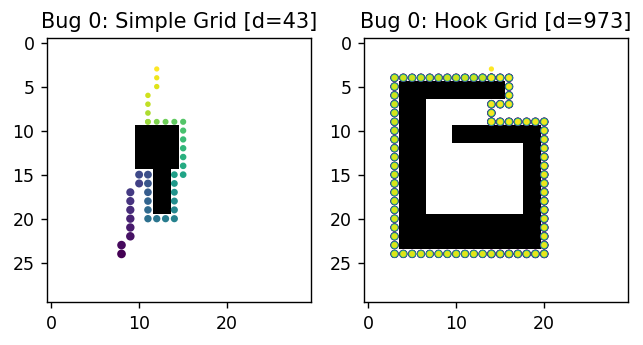

In [2]:
# Bug 0 (incomplete)

def bug_0(grid, start, goal, verbose=False, max_steps=1000):
    all_positions = []
    line = bresenham_points(start, goal)
    robot = BugRobot(position=start,
                     orientation=np.array([1, 0]))

    follow_line = True
    for _ in range(max_steps):
        all_positions.append(robot.position.copy())
        if verbose:
            print(f"Position: {robot.position} | "
                  f"Orientation: {robot.orientation} | "
                  f"Is On Line: {robot.is_on_line(line)}")

        if follow_line:
            # Follow the line until we cannot
            did_encounter_obstacle = robot.follow_line(grid, line)
            if did_encounter_obstacle:
                follow_line = False
        else:
            # Follow the object until we encounter
            robot.follow_object(grid)
            if robot.is_on_line(line):
                follow_line = True

        if (robot.position == goal).all():
            break
                
    return np.array(all_positions).T


# Plotting Code
plt.figure(dpi=125)

# - Simple Grid + Bug 0
plt.subplot(1, 2, 1)
grid = make_simple_grid()
start = np.array([3, 12])
goal = np.array([25, 8])
path = bug_0(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 0: Simple Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [simple]: {int(manhattan_path_length(path))}")

# - Hook Grid + Bug 0
plt.subplot(1, 2, 2)
grid = make_hook_grid()
start = np.array([3, 14])
goal = np.array([15, 14])
path = bug_0(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 0: Hook Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [hook]: {int(manhattan_path_length(path))}")

plt.show()

**PLOT** Include these two plots in your writeup.

**QUESTION** [2-3 sentences] (Include the answer in your writeup.) The path length in the Hook Grid example is very long and does not reach the goal. Briefly describe why this has occurred.

### P1.1.2 Bug 1 

Implement Bug 1 and run the plotting code following it (see the next 2 code blocks). *Note*: I have given you some starter code down below that includes some structure for how the Bug 1 code should look. I have added comments and `NotImplementedError` messages to indicate where you should add new code. Be sure to take a look back at the lecture slides and pseudocode if you have trouble understanding what's going on. Also, notice that whenever you want to store `robot.position`, you must `copy()` it first; remembering this will help to avoid issues later on.

In [18]:
# Starter code for P1.2 (Bug 1)
import math

def bug_1(grid, start, goal, verbose=False, max_steps=1000):
    all_positions = []
    line = bresenham_points(start, goal)
    robot = BugRobot(position=start,
                     orientation=np.array([1, 0]))

    follow_line = True
    looping_back = False
    for _ in range(max_steps):
        all_positions.append(robot.position.copy())
        
        # Break when we reach the goal
        if (robot.position == goal).all():
            break
        
        if verbose:
            print(f"Position: {robot.position} | "
                  f"Orientation: {robot.orientation} | "
                  f"Is On Line: {robot.is_on_line(line)}")

        if follow_line:
            # Follow the line until we cannot
            did_encounter_obstacle = robot.follow_line(grid, line)
            if did_encounter_obstacle:
                follow_line = False
                # The robot remembers where it started.
                obstacle_start_position = robot.position.copy()
                obstacle_closest_position = robot.position.copy()
        elif looping_back:
            # Follow the object until we reach the closest point
            # and recompute the line.
            robot.follow_object(grid)
            if (robot.position == obstacle_closest_position).all():  # When should you stop looping back around the object and follow the line again?
                line = bresenham_points(robot.position, goal)
                looping_back = False
                follow_line = True
            if (robot.position == obstacle_start_position).all(): 
                break
        else:
            # Follow the object until we loop back to our start position
            # Then set 'looping_back' to True
            robot.follow_object(grid)
            dist_current = math.hypot(goal[0] - robot.position[0], goal[1] - robot.position[1])
            dist_old = math.hypot(goal[0] - obstacle_closest_position[0], goal[1] - obstacle_closest_position[1])
            if dist_current < dist_old:
                obstacle_closest_position = robot.position.copy()
            if (robot.position == obstacle_start_position).all():
                looping_back = True

    return np.array(all_positions).T

Travel Distance (Manhattan Norm) [simple]: 68
Travel Distance (Manhattan Norm) [hook]: 172
Travel Distance (Manhattan Norm) [maze 0]: 6074
Travel Distance (Manhattan Norm) [maze 1]: 4896


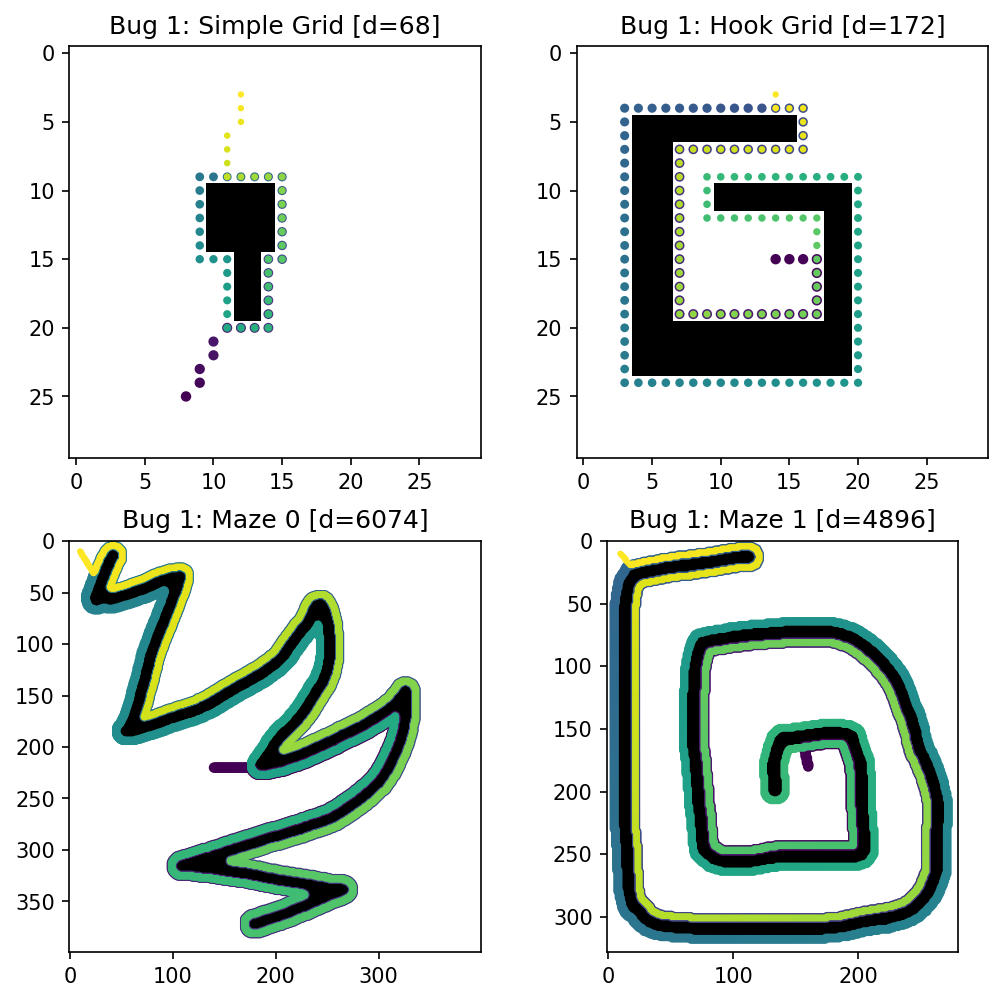

In [27]:
# Plotting Code

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

plt.figure(dpi=150, figsize=(8, 8))

# - Simple Grid + Bug 1
plt.subplot(2, 2, 1)
grid = make_simple_grid()
start = np.array([3, 12])
goal = np.array([25, 8])
path = bug_1(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 1: Simple Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [simple]: {int(manhattan_path_length(path))}")

# - Hook Grid + Bug 1
plt.subplot(2, 2, 2)
grid = make_hook_grid()
start = np.array([3, 14])
goal = np.array([15, 14])
path = bug_1(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 1: Hook Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [hook]: {int(manhattan_path_length(path))}")

# - Maze 0 + Bug 1
plt.subplot(2, 2, 3)
grid = (load_image("images/maze_0.png")[:, :, 0] < 0.5).astype(int)
start = np.array([10, 10])
goal = np.array([220, 140])
path = bug_1(grid, start, goal, verbose=False, max_steps=10000)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 1: Maze 0 [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [maze 0]: {int(manhattan_path_length(path))}")

# - Maze 1 + Bug 1
plt.subplot(2, 2, 4)
grid = (load_image("images/maze_1.png")[:, :, 0] < 0.5).astype(int)
start = np.array([10, 10])
goal = np.array([180, 160])
path = bug_1(grid, start, goal, verbose=False, max_steps=10000)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 1: Maze 1 [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [maze 1]: {int(manhattan_path_length(path))}")


plt.show()

**IMPLEMENT** If you "only" followed along with my code above, you may find that your planner never ends for the 4th plot! This is undesirable, and you should augment your implementation to ensure the execution terminates. One sign the planner is stuck is when the "starting point" when you start following the obstacle is the same as the point where you start following the line again. Add this check to your code and ensure that the code terminates early when it realizes it cannot reach the goal.

**PLOT** Include the resulting plots (should have 4 images) in your writeup.

**CODE LISTING** Include your finished Bug 1 implementation in your writeup, which should include your "early termination" failure condition.

### P1.1.3 Bug 2

**IMPLEMENT** Implement Bug 2! The starter code for this question is very close to my `bug_0` implementation above. Also, ensure that the algorithm terminates (and does not go on "forever" in the second maze)! Refer back to the pseudocode implementation from class if you are not following along.

In [5]:
## Starter code for the bug_2 implementation
import math

def bug_2(grid, start, goal, verbose=False, max_steps=1000):
    all_positions = []
    
    # The line now extends *beyond* the goal (important for checking intersection)
    term = 5 * goal - 4 * start
    line = bresenham_points(start, term)
    robot = BugRobot(position=start,
                     orientation=np.array([1, 0]))

    follow_line = True
    looping_back = False
    for _ in range(max_steps):
        all_positions.append(robot.position.copy())
        
        if (robot.position == goal).all():
            break
        
        if verbose:
            print(f"Position: {robot.position} | "
                  f"Orientation: {robot.orientation} | "
                  f"Is On Line: {robot.is_on_line(line)}")

        if follow_line:
            # Follow the line until we cannot
            did_encounter_obstacle = robot.follow_line(grid, line, goal)
            if did_encounter_obstacle:
                follow_line = False
                last_m_line_position = robot.position.copy()
        else:
            # Follow the object until [??]
            robot.follow_object(grid)
            if robot.is_on_line(line):
                dist_current = math.hypot(goal[0] - robot.position[0], goal[1] - robot.position[1])
                dist_old = math.hypot(goal[0] - last_m_line_position[0], goal[1] - last_m_line_position[1])
                if dist_current < dist_old:
                    follow_line = True
                if (robot.position == last_m_line_position).all():
                    break

    return np.array(all_positions).T

Travel Distance (Manhattan Norm) [simple]: 44
Travel Distance (Manhattan Norm) [hook]: 116
Travel Distance (Manhattan Norm) [maze 0]: 3066
Travel Distance (Manhattan Norm) [maze 1]: 10046


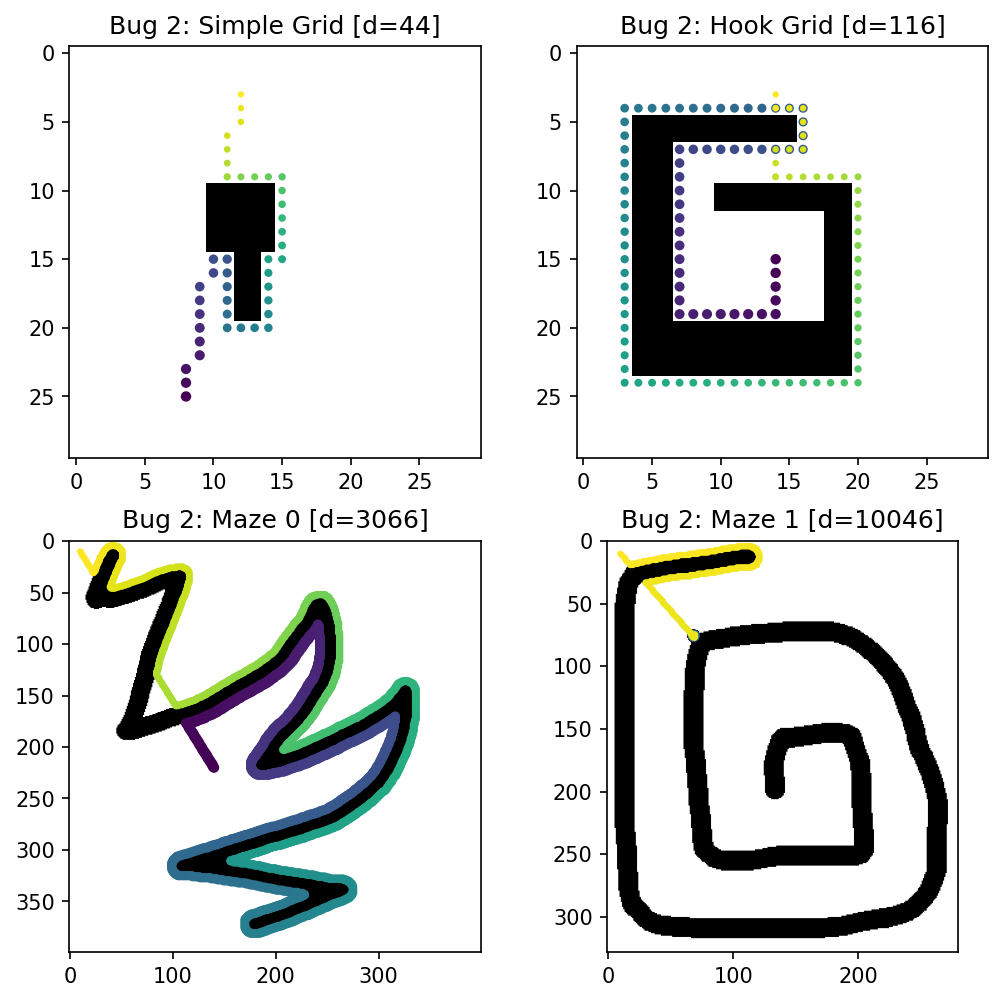

In [31]:
# Plotting Code

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

plt.figure(dpi=150, figsize=(8, 8))

# - Simple Grid + Bug 1
plt.subplot(2, 2, 1)
grid = make_simple_grid()
start = np.array([3, 12])
goal = np.array([25, 8])
path = bug_2(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 2: Simple Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [simple]: {int(manhattan_path_length(path))}")

# - Hook Grid + Bug 1
plt.subplot(2, 2, 2)
grid = make_hook_grid()
start = np.array([3, 14])
goal = np.array([15, 14])
path = bug_2(grid, start, goal, verbose=False)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 2: Hook Grid [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [hook]: {int(manhattan_path_length(path))}")

# - Maze 0 + Bug 1
plt.subplot(2, 2, 3)
grid = (load_image("images/maze_0.png")[:, :, 0] < 0.5).astype(int)
start = np.array([10, 10])
goal = np.array([220, 140])
path = bug_2(grid, start, goal, verbose=False, max_steps=10000)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 2: Maze 0 [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [maze 0]: {int(manhattan_path_length(path))}")

# - Maze 1 + Bug 1
plt.subplot(2, 2, 4)
grid = (load_image("images/maze_1.png")[:, :, 0] < 0.5).astype(int)
start = np.array([10, 10])
goal = np.array([180, 160])
path = bug_2(grid, start, goal, verbose=False, max_steps=10000)
plot_scene(plt.gca(), grid, path=path)
plt.title(f"Bug 2: Maze 1 [d={int(manhattan_path_length(path))}]")
print(f"Travel Distance (Manhattan Norm) [maze 1]: {int(manhattan_path_length(path))}")

plt.show()

## P1.2 State Space Search: Sliding Puzzles
In class, we saw an example of a "Sliding Puzzle", in which a grid-like puzzle contains numbers and an "empty square" into which these numbers can be slid to change the state of the puzzle. The classic example of this is a "Sliding 15 Puzzle", which is a 4x4 grid, containing the numbers 1--15 and an empty square. I have provided you with an implementation of this puzzzle below, which you can use to solve the remainder of the question.

Here you will be exploring and implementing *state space search*, in which you try to find a goal state from a random initial configuration for Sliding Puzzles of various sizes. State space search will be a very important capability for the remainder of the course, so try to make sure you understand the starter code I give you as well as your own solution.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random


class SlidingPuzzle(object):
    def __init__(self, nrows=3, ncols=3, state=None):
        self.nrows = nrows
        self.ncols = ncols
        if state is None:
            self.state = np.array(list(range(1, nrows * ncols)) + [0])
        else:
            self.state = state
            
    def randomize(self, num_iterations=100):
        rand_puzzle = self
        for _ in range(num_iterations):
            rand_puzzle = random.choice(rand_puzzle.get_children())
        self.state = rand_puzzle.state
        return self
    
    def get_swapped_puzzle(self, zero_ind, swap_ind):
        state = self.state.copy()
        state[zero_ind], state[swap_ind] = state[swap_ind], state[zero_ind]
        return SlidingPuzzle(nrows=self.nrows,
                             ncols=self.ncols,
                             state=state)
        
    def get_children(self):
        ind = np.argwhere(self.state == 0)[0, 0]
        swap_inds = []
        ncols = self.ncols
        
        if ind - self.ncols >= 0:
            swap_inds.append(ind - ncols)
        if ind + self.ncols < self.nrows * self.ncols:
            swap_inds.append(ind + ncols)
        if ((ind - 1) // self.ncols) == ((ind) // self.ncols):
            swap_inds.append(ind - 1)
        if ((ind + 1) // self.ncols) == ((ind) // self.ncols):
            swap_inds.append(ind + 1)

        return [self.get_swapped_puzzle(ind, sind) for sind in swap_inds]

    def print(self):
        print(np.reshape(self.state, (self.nrows, self.ncols)))
        
    def get_reshaped_state(self):
        return np.reshape(self.state, (self.nrows, self.ncols))

    def __eq__(self, other):
        return len(self.state) == len(other.state) and (self.state == other.state).all()

    def __str__(self):
        return str(self.get_reshaped_state())

    def __hash__(self):
        return hash(tuple(self.state))
    
    def plot_puzzle(self):
        reshaped_state = self.get_reshaped_state()
        plt.imshow(reshaped_state)
        
        # From: https://stackoverflow.com/a/33829001
        for (j,i),label in np.ndenumerate(reshaped_state):
            plt.text(i,j,label,ha='center',va='center')
            plt.text(i,j,label,ha='center',va='center')
        
        plt.gca().xaxis.set_ticks([])
        plt.gca().yaxis.set_ticks([])

The implementation of the Sliding 8 puzzle includes a function called `get_children()` which produces all states that can be reached from a state. For example, if we get a random state (via `puzzle = SlidingPuzzle().randomize()`), we can print out all the "children" from this state and plot them as follows:

Starting State:
[[5 1 3]
 [2 0 7]
 [8 6 4]]
Child #1:
[[5 0 3]
 [2 1 7]
 [8 6 4]]
Child #2:
[[5 1 3]
 [2 6 7]
 [8 0 4]]
Child #3:
[[5 1 3]
 [0 2 7]
 [8 6 4]]
Child #4:
[[5 1 3]
 [2 7 0]
 [8 6 4]]


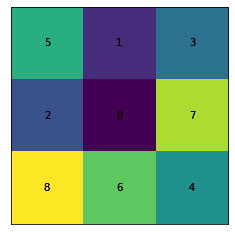

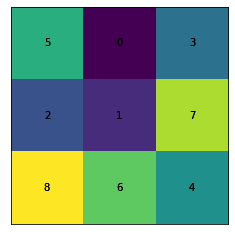

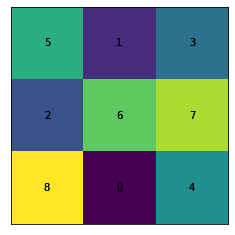

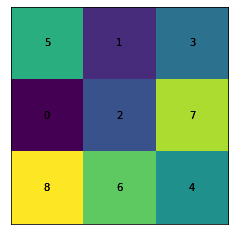

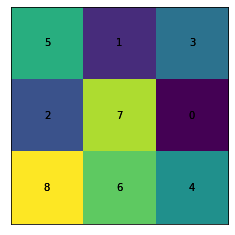

In [3]:
random.seed(695)
puzzle = SlidingPuzzle().randomize()
print("Starting State:")
print(puzzle)
plt.figure()
puzzle.plot_puzzle()
for ii, child_state in enumerate(puzzle.get_children()):
    print(f"Child #{ii+1}:")  # empty line
    print(child_state)
    plt.figure()
    child_state.plot_puzzle()

The states are also hashable, which means we can use them in a Python 'set' object, which is like a list, but (1) unordered and (2) does not allow duplicates. Here are some examples (the assert statements will return an error if false):

In [4]:
random.seed(695)
puzzle = SlidingPuzzle().randomize()
# A set cannot contain two of the same object
a_set = set([puzzle])
a_set.add(puzzle)
assert len(a_set) == 1

# We can add two sets using .union; this will remove duplicates
all_near_states_set = set([puzzle]).union(puzzle.get_children())
only_children_set = set(puzzle.get_children())
merged_sets = a_set.union(only_children_set)
assert len(only_children_set) + 1 == len(all_near_states_set)
assert len(merged_sets) == len(all_near_states_set)

### P1.2.1 Expanding States

First, before we implement search, you should experiment with *generating* all the states reachable from some starting state. For this purpose, the `get_children` function will be most useful.

**TASK** Create a function `expand_states` that takes in a set of states `start_states` and return another set that contains all the elements of `start_states` as well as all states reachable from those states (which means adding all the children for each state). This is an exercise in exploring the *state space*. To implement this function, loop through all states in `start_states`, generate all the children of all those states, and then add those children to an array `new_states` that is "unioned" with the start states. Feel free to start with the starter function in the code block below.

In [5]:
# Starter code: expand function
def expand_states(start_states):
    new_states = set([])
    for states in start_states:
        new_states = new_states.union(set(states.get_children()))
    return start_states.union(new_states)

**PLOTS** I have provided you with some plotting code below the starter code (under `Plotting: Expanding the states`) that iteratively uses your expansion function to compute plots that show (1) the log-number of states after each expansion and (2) the ratio of states between levels. This is computed for sliding puzzles of different sizes. Include these plots in your writeup (and try to understand what they mena).

**QUESTION** (2-4 sentences) You should see in both plots that the number of states levels off and asymptotically approaches a constant value and actually reaches that value for the 2x2 grid (and perhaps for the 3x3 grid as well). Why does this occur? What does it mean when the expansion ratio (the right plot) reaches 1?

Interestingly enough, the total number of states of the puzzle should be `(height * width)!` (factorial), but the number of states that can be *reached* is less than this.

**QUESTION** (2-4 sentences) Run `expand_states` for a 3x2 grid for `num_iterations=30`; what is the total number of states reached after 30 iterations? How does this value compare to `(3 * 2)! = 720`? Is this ratio the same for the `2x2` grid and `(2 * 2)! = 24`?

(The reason for this has to do with the fact that each action only swaps two neighboring values; reaching some states would require swapping non-neighbors.)

Start State:
[[1 2]
 [3 0]]
Num States after 0 iterations: 1
Num States after 1 iterations: 3
Num States after 2 iterations: 5
Num States after 3 iterations: 7
Num States after 4 iterations: 9
Num States after 5 iterations: 11
Num States after 6 iterations: 12
Num States after 7 iterations: 12
Num States after 8 iterations: 12
Num States after 9 iterations: 12
Num States after 10 iterations: 12
Num States after 11 iterations: 12
Num States after 12 iterations: 12
Num States after 13 iterations: 12
Num States after 14 iterations: 12
Num States after 15 iterations: 12
Num States after 16 iterations: 12
Num States after 17 iterations: 12
Num States after 18 iterations: 12
Num States after 19 iterations: 12
Num States after 20 iterations: 12
Num States after 21 iterations: 12
Num States after 22 iterations: 12
Num States after 23 iterations: 12
Num States after 24 iterations: 12
Num States after 25 iterations: 12
Num States after 26 iterations: 12
Num States after 27 iterations: 12
Num Sta

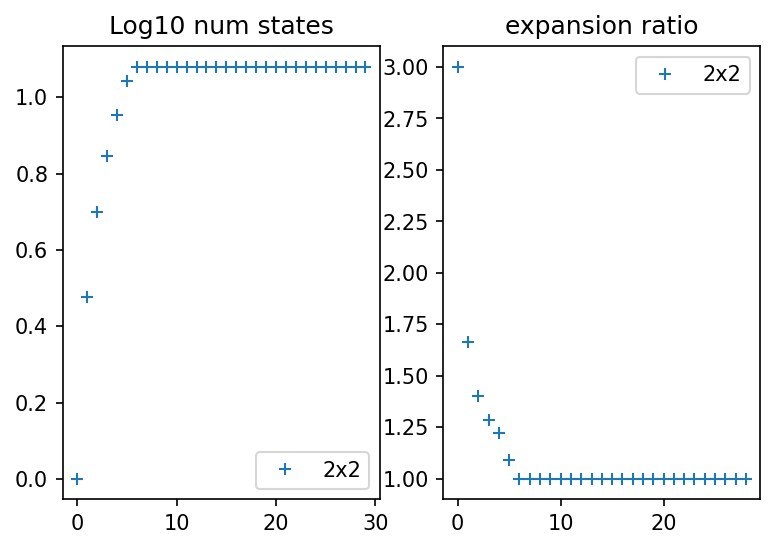

In [37]:
# Plotting: Expanding the states (might take a minute to run)
import matplotlib.pyplot as plt
import random

random.seed(695)
start_state = SlidingPuzzle(3, 3).randomize()

def get_num_states_per_expansion(start_state, verbose=True, num_iterations=24):
    if verbose:
        print("Start State:")
        print(start_state)
    all_states = set([start_state])
    count_list = []
    
    for ii in range(num_iterations):
        if ii > 0:
            all_states = expand_states(all_states)
        num = len(all_states)
        if verbose:
            print(f"Num States after {ii} iterations: {num}")
            
        count_list.append(num)
    
    return count_list


# Generate the data from running the function
count_list_2x2 = get_num_states_per_expansion(SlidingPuzzle(2, 2).randomize(), verbose=False)
count_list_3x2 = get_num_states_per_expansion(SlidingPuzzle(3, 2).randomize(), verbose=True)
count_list_4x2 = get_num_states_per_expansion(SlidingPuzzle(4, 2).randomize(), verbose=False)
count_list_3x3 = get_num_states_per_expansion(SlidingPuzzle(3, 3).randomize(), verbose=False)

# Make the plots
plt.figure(dpi=150)
plt.subplot(121)
plt.plot(np.log10(count_list_2x2), '+')
plt.plot(np.log10(count_list_3x2), 'x')
plt.plot(np.log10(count_list_4x2), '*')
plt.plot(np.log10(count_list_3x3), '.')
plt.legend(['2x2', '3x2', '4x2', '3x3'])
plt.title('Log10 num states')

plt.subplot(122)
plt.plot([a/b for a, b in zip(count_list_2x2[1:], count_list_2x2)], '+')
plt.plot([a/b for a, b in zip(count_list_3x2[1:], count_list_3x2)], 'x')
plt.plot([a/b for a, b in zip(count_list_4x2[1:], count_list_4x2)], '*')
plt.plot([a/b for a, b in zip(count_list_3x3[1:], count_list_3x3)], '.')
plt.legend(['2x2', '3x2', '4x2', '3x3'])
plt.title('expansion ratio')
None


### P1.2.2 Implementing Search

**TASK** Implement Breadth First Search and Depth First Search.

Both of these functions will have a similar structure. Start by using the pseudocode provided to you in lecture L02. The general procedure involves keeping track of two data structures:
- `Q` is a list of lists. Each list in `Q` is a "path" of visited states, a sequence beginning with the `start` state and ending with the most recently visited state for that path.
- `visited` is a set containing all states that you've been to before (so that you don't go back to them again).
At each iteration, get the "path to explore" (notated as `N` in the pseudocode from class), generate all its children and (for each) if its not in the visited list (1) add it to the visited list and (2) add new paths `N + [child]` to `Q`. A few tips:
- When you add new paths to `Q`, be sure to keep track of whether the newest paths are being added to the front or back. When you get a new path to explore `N`, you will want to take the newest or oldest paths depending on whether you are doing breadth-first or depth-first search.
- Don't forget to update `Q` when you get `N`. You don't want to be stuck in a loop forever...
- You should return `N` when it contains the goal state (which will usually be the last state).
- You may want to debug with the 2x2 and 3x2 examples first. This will be easier and faster.

**CODE LISTING** Include your implementation of one (or both) search algorithms in your writeup. [I expect they will be very similar to one another; I only intend to grade one of them.]

**RESULTS** I have provided you with some code that generates results and prints them to the command line for 3 different seeds. Include in your writeup a data table including the (1) path length, (2) number of iterations, and (3) for both Breadth First and Depth First Search for each of the 3 seeds (for a total of 2 * 3 * 2=12 numbers).

**QUESTION** (2-4 sentences) For the different seeds, was the path generated from Depth First or Breadth First shorter? Describe why this is the case using theoretical arguments from class.

**QUESTION** (1-2 sentences) If I were to ask you to find the optimal path to solve a 3x3 sliding puzzle, which algorithm should you use? Why?

**PLOT** I have included some plotting code under `Plotting code: Plot the paths for the 3x2 examples` below that allows you to visualize a "solution path" below.  This solves a 3x2 puzzle and visualizes (some of) the solution for both search approaches. Include both plots in your writeup and be sure to label which is which.

In [7]:
# Stub of search functions [my completed functions are roughly 25 lines of code each]
import time

def breadth_first_search(start, goal, max_iterations=100000):
    Q = [[start]]
    visited = set([start])
    stime = time.time()
    for ind in range(max_iterations):
        # First get N from Q and update Q
        N = Q.pop(0)
        # Check if the goal has been reached
        if N[-1] == goal:
            return {
                'succeeded': True,
                'path': N,
                'num_iterations': ind,
                'path_len': len(N),
                'num_visited': len(visited),
                'time': time.time() - stime,
            }
        
        vertices = N[-1].get_children()
        for vertex in vertices: 
            if vertex not in visited:
                visited.add(vertex)
                Q.append(N + [vertex])
        # Then add new paths to Q from N (and its children)
    return {'succeeded': False}


def depth_first_search(start, goal, max_iterations=100000):
    Q = [[start]]
    visited = set([start])
    stime = time.time()
    for ind in range(max_iterations):
        # First get N from Q and update Q
        N = Q.pop()
        # Check if the goal has been reached
        if N[-1] == goal:
            return {
                'succeeded': True,
                'path': N,
                'num_iterations': ind,
                'path_len': len(N),
                'num_visited': len(visited),
                'time': time.time() - stime,
            }
        
        vertices = N[-1].get_children()
        for vertex in vertices: 
            if vertex not in visited:
                visited.add(vertex)
                Q.append(N + [vertex])
        # Then add new paths to Q from N (and its children)
    return {'succeeded': False}

In [40]:
# Results Generation [after completing your code, run this]

puzzle_sizes = [(2, 2)]

def generate_results_for_seed(seed):
    print("")
    print(f"Results for seed: {seed}")
    for rows, cols in puzzle_sizes:
        print(f"== Start puzzle for [{rows}x{cols}]")
        random.seed(seed)
        puzzle = SlidingPuzzle(rows, cols).randomize()
        goal = SlidingPuzzle(rows, cols)

        # Solve using search
        bf_dat = breadth_first_search(puzzle, goal)
    
        if bf_dat['succeeded']:
            print("Breadth First Succeeded:")
            print(f"  BF Iterations: {bf_dat['num_iterations']}")
            print(f"  BF Path Length: {bf_dat['path_len']}")
            print(f"  BF Num Visited: {bf_dat['num_visited']}")
            print(f"  BF Time: {bf_dat['time']}")
        else:
            print("Breadth First Failed (max iterations)")
        
        df_dat = depth_first_search(puzzle, goal)
        if df_dat['succeeded']:
            print("Depth First Succeeded:")
            print(f"  DF Iterations: {df_dat['num_iterations']}")
            print(f"  DF Path Length: {df_dat['path_len']}")
            print(f"  DF Num Visited: {df_dat['num_visited']}")
            print(f"  DF Time: {df_dat['time']}")
        else:
            print("Depth First Failed (max iterations)")

generate_results_for_seed(2824)
generate_results_for_seed(10034)
generate_results_for_seed(4132)
generate_results_for_seed(3246)
generate_results_for_seed(2245)
generate_results_for_seed(10028)
generate_results_for_seed(7921)
generate_results_for_seed(5739)
generate_results_for_seed(5633)
generate_results_for_seed(3898)
generate_results_for_seed(6786)
generate_results_for_seed(5629)
generate_results_for_seed(8358)
generate_results_for_seed(1565)
generate_results_for_seed(4516)
generate_results_for_seed(9625)
generate_results_for_seed(3290)
generate_results_for_seed(5827)
generate_results_for_seed(5066)
generate_results_for_seed(4496)
generate_results_for_seed(5926)
generate_results_for_seed(9278)
generate_results_for_seed(7356)
generate_results_for_seed(1325)
generate_results_for_seed(3393)
generate_results_for_seed(7369)
generate_results_for_seed(3021)
generate_results_for_seed(6128)
generate_results_for_seed(1010)
generate_results_for_seed(8611)
generate_results_for_seed(1869)
generate_results_for_seed(8418)
generate_results_for_seed(7253)
generate_results_for_seed(9028)
generate_results_for_seed(3461)
generate_results_for_seed(2859)
generate_results_for_seed(7066)
generate_results_for_seed(4094)
generate_results_for_seed(4310)
generate_results_for_seed(821)
generate_results_for_seed(3611)
generate_results_for_seed(3517)
generate_results_for_seed(6350)
generate_results_for_seed(8269)
generate_results_for_seed(1152)
generate_results_for_seed(6861)
generate_results_for_seed(7444)
generate_results_for_seed(7017)
generate_results_for_seed(1409)
generate_results_for_seed(7105)
generate_results_for_seed(8822)
generate_results_for_seed(9534)
generate_results_for_seed(5834)
generate_results_for_seed(6893)
generate_results_for_seed(965)
generate_results_for_seed(6589)
generate_results_for_seed(888)
generate_results_for_seed(4814)
generate_results_for_seed(1079)
generate_results_for_seed(8681)
generate_results_for_seed(6027)
generate_results_for_seed(9227)
generate_results_for_seed(9428)
generate_results_for_seed(4767)
generate_results_for_seed(8233)
generate_results_for_seed(4207)
generate_results_for_seed(4914)
generate_results_for_seed(7005)
generate_results_for_seed(524)
generate_results_for_seed(7388)
generate_results_for_seed(5428)
generate_results_for_seed(6769)
generate_results_for_seed(3053)
generate_results_for_seed(1524)
generate_results_for_seed(6109)
generate_results_for_seed(2394)
generate_results_for_seed(9470)
generate_results_for_seed(1792)
generate_results_for_seed(1282)
generate_results_for_seed(8674)
generate_results_for_seed(10407)
generate_results_for_seed(6415)
generate_results_for_seed(1464)
generate_results_for_seed(5808)
generate_results_for_seed(6518)
generate_results_for_seed(6869)
generate_results_for_seed(5962)
generate_results_for_seed(2575)
generate_results_for_seed(1160)
generate_results_for_seed(1516)
generate_results_for_seed(698)
generate_results_for_seed(3173)
generate_results_for_seed(6432)
generate_results_for_seed(5658)
generate_results_for_seed(7033)
generate_results_for_seed(7268)
generate_results_for_seed(387)
generate_results_for_seed(6123)
generate_results_for_seed(8483)
generate_results_for_seed(8426)
generate_results_for_seed(7375)
generate_results_for_seed(7118)


4
4
10
12
12
10
6
10
10
12
4
1
10
8
12
10
8
12
10
8
12
10
8
12
6
8
1
12
4
6
12
6
10
8
8
12
10
6
12
8
4
8
4
12
6
8
8
8
4
1
8
4
12
4
12
6
10
8
8
6
1
6
6
4
1
12
6
8
1
10
4
8
1
1
4
12
1
10
4
8
1
1
8
6
8
6
6
4
6
8
12
12
4
6
1
4
12
8
1
12
4
12


Start puzzle for [3x2]
13
4 4
71
9 9


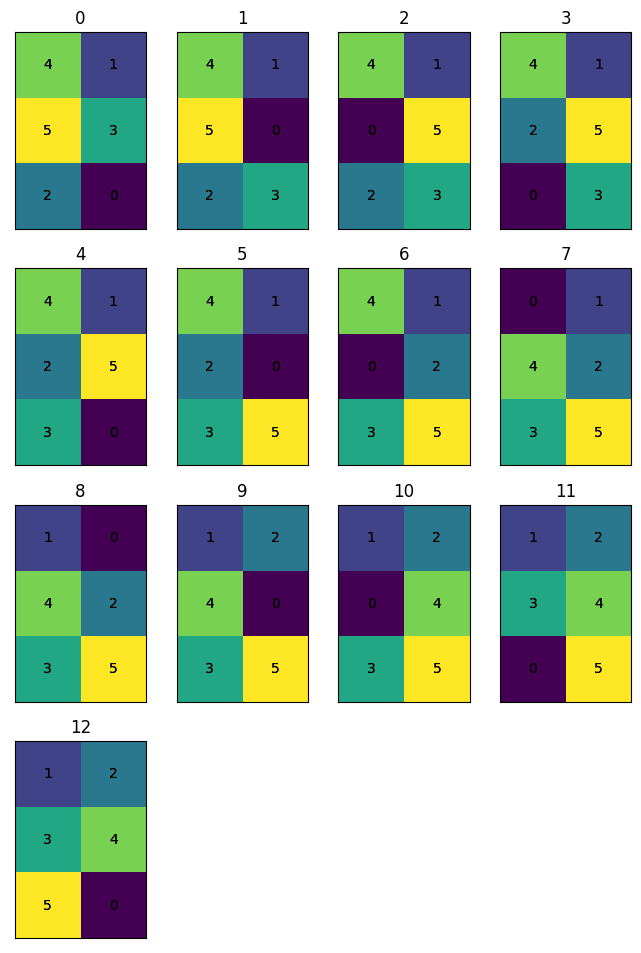

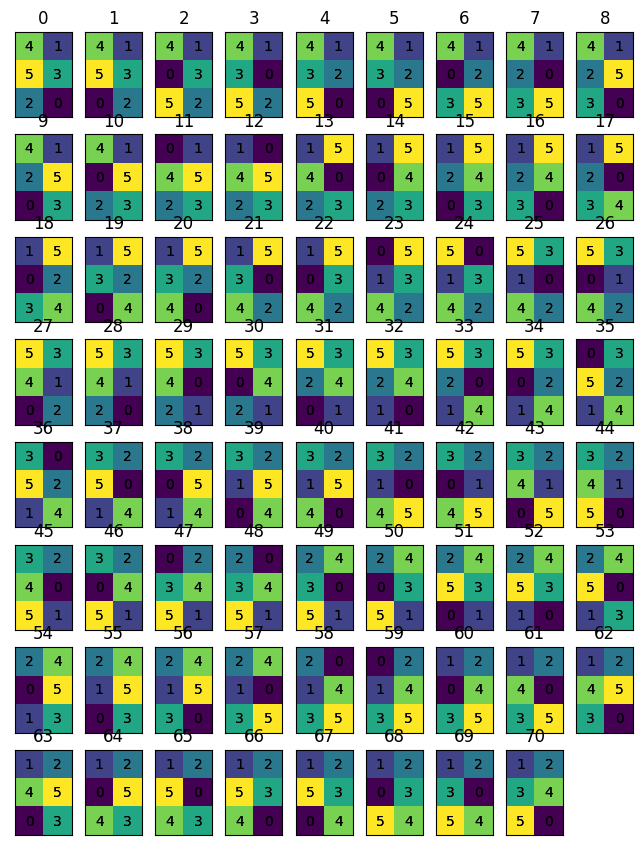

In [8]:
# Plotting code: Plot the paths for the 3x2 examples.

rows = 3
cols = 2
print(f"Start puzzle for [{rows}x{cols}]")
random.seed(695)
puzzle = SlidingPuzzle(rows, cols).randomize()
goal = SlidingPuzzle(rows, cols)

def plot_sliding_solution(path):
    print(len(path))
    nrows = int(np.floor(np.sqrt(len(path[:100]))+1))
    ncols = int(np.ceil(np.sqrt(len(path[:100]))))
    print(nrows, ncols)
    for ii, state in enumerate(path[:100]):
        plt.subplot(nrows, ncols, ii + 1)
        reshaped_state = state.get_reshaped_state()
        state.plot_puzzle()
        plt.title(str(ii))


# Solve using search
bf_dat = breadth_first_search(puzzle, goal)
plt.figure(figsize=[8, 12], dpi=100)
plot_sliding_solution(bf_dat['path'])

df_dat = depth_first_search(puzzle, goal)
plt.figure(figsize=[8, 12], dpi=100)
plot_sliding_solution(df_dat['path'])

None

### P1.2.3 Statistical Analysis

Many times we develop and run our planning algorithms, it helps to understand their emperical performance, which we can use to compute statistics of values of interest. Here, you will modify the `Results Generation` code block from above to return the data from each run (each run is defined by a randomly generated start configuration and the goal state, which is the same for all puzzles of a given size).

**RESULTS** Generate results for 100 random seeds (or more if you'd like) for the 2x2, 3x2, and 4x2 sliding puzzles for both planners (breadth-first and depth-first). Compute the mean and standard deviation for the path length and number of states visited and add these values to your data tables. *Note:* it is common practice to include the mean and std. dev. in a single "box" in a table: e.g., $1.0 \pm 0.2$. Also, if you standard deviation is zero for any of the runs, it might mean that you aren't properly varying your random seed. [If any of the searches do not succeed: include "reasonable" values for the path length and states visited.]

There is otherwise no starter code for this subproblem.

## P1.3: Docker, CGAL, and Voronoi Decompositions

The primary purpose of this question is to familiarize you with some of the tools that we may encounter later in this class or that you may want to use for your final project. CGAL is a computational geometry library I mentioned in class, but installing it and building code with it can be finicky. I have provided you with a *Dockerfile* that can be used to run the code in a (somewhat easy-to-use) encapsulated environment. If you're unfamiliar with Docker, it's a fantastic tool that we use for most of the development in my lab; it's easiest to think of Docker as a "virtual machine" (like VMWare or Virtual Box) that runs a stripped-down version of Ubuntu that's installed from the ground up with a set of install or build commands as defined in the Dockerfile. It makes it easy to build and run code without needing to install things globally (like a Python virtual environment, but for your entire OS). Follow these steps to build and run the code I've provided:

- *Step 0* If you don't have GNU `Make` installed on your computer you should install it first: https://www.gnu.org/software/make/
- *Step 1* Install Docker on your machine from here: https://docs.docker.com/get-docker/
- *Step 2* Open a terminal, `cd` into the folder containing this Jupyter notebook, and run `make run-cgal`. This `make` command will first build the Docker container---which both loads up Ubuntu and then builds the CGAL code I have provided---and then runs the code, consuming the data file I have provided and producing an output (described below).

When you have finished running the code inside the Docker container, you should notice a new file in the `results` folder. The code is generated using the [2D Voronoi Diagram Adaptor](https://doc.cgal.org/latest/Voronoi_diagram_2/index.html#secvda2intro) from CGAL. The rows of this data file define polygons, each of which represents a region that is closest to a particular line segment. Moving in the plane and crossing from one to another means that you have moved closer to a different polygon. The code below plots those lines on top of the starting data.

**PLOT** After you've run the CGAL code from inside the Docker container, run the plotting code below. You should see both blue lines (spelling out `CS 695`) and gray lines (the Voronoi decomposition of the space). If you do not see the gray lines, your Docker container may not have built properly. Include this plot in your writeup.

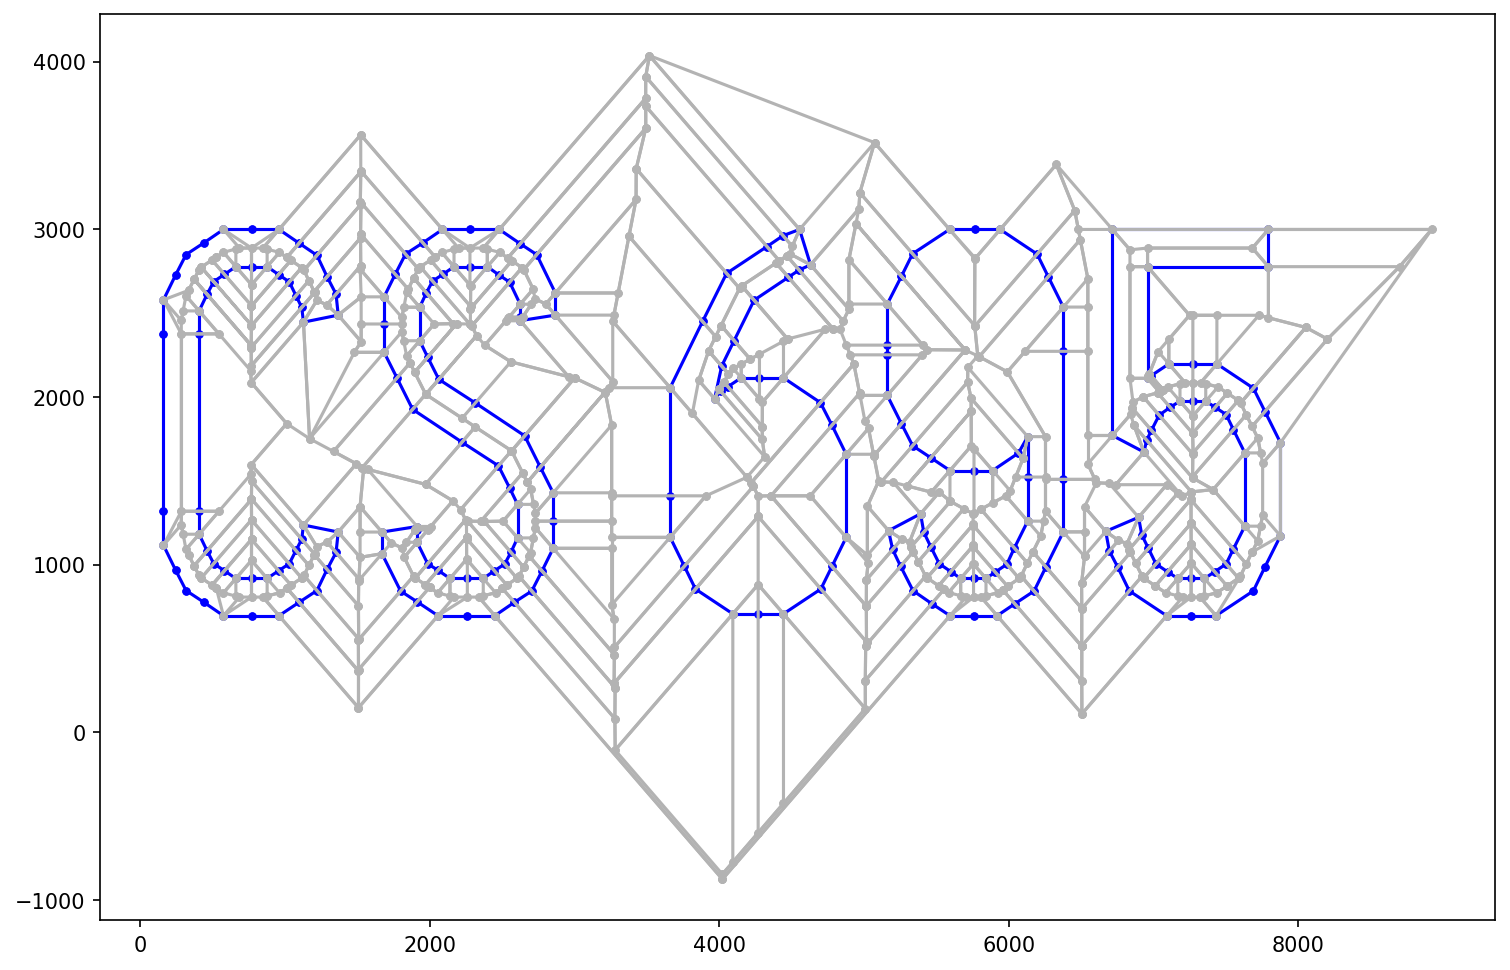

In [38]:
# CGAL: Plotting the results

import numpy as np
import matplotlib.pyplot as plt
import os

plt.figure(figsize=[12, 8], dpi=150)

path = os.path.join(os.path.dirname(os.path.realpath("__file__")), 
                             'src', 'data', 'data_cs695.cin')
map_lines = []
with open(path) as f:
    lines = f.readlines()
    for line in lines:
        map_lines.append([float(num) for num in line[2:].split(" ")])

for map_line in map_lines:
    plt.plot(map_line[::2], map_line[1::2], 'b.-')


# Next, get and plot the Voronoi lines (from CGAL)
path = os.path.join(os.path.dirname(os.path.realpath("__file__")), 
                             'results', 'voronoi_lines.txt')
voronoi_lines = []
with open(path) as f:
    lines = f.readlines()
    for line in lines:
        voronoi_lines.append([float(num) for num in line.split(" ")[:-1]])

for voronoi_line in voronoi_lines:
    plt.plot(voronoi_line[::2], voronoi_line[1::2], '.-', color='0.7', alpha=1.0)